In [1]:
from Sampling_Quantum import *
from New_MCMC_Proposal import *
from get_conn import get_conn

In [2]:
# pip install qiskit

In [3]:
# pip install netket

In [4]:
import os
import numpy as np
#import netket as nk
import scipy as sp
import numpy.linalg as la
import scipy.linalg as spla
import time
import matplotlib.pyplot as plt
import json

In [5]:
import itertools
#from qiskit.quantum_info import Pauli, SparsePauliOp
from collections import defaultdict

In [6]:
# from netket.operator import LocalOperator
# from netket.operator.spin import sigmax, sigmay, sigmaz, identity

In [7]:
from cudaq import spin
import cudaq

def TFIM(N,g):
    hamiltonian = 0
    for i in range(N-1):
        hamiltonian -= spin.z(i) * spin.z(i+1)

    for i in range(N):
        hamiltonian -= g*spin.x(i)
    return hamiltonian

In [64]:
N=10
M=10
D=0
beta=1

In [65]:
def init(seed=1, vv=False, complex=True, a=[], b=[], w=[]):
  np.random.seed(seed)
  if complex==True:
    X=np.random.randn(N+M+N*M+N*D+D+N*N)+1j*np.random.randn(N+M+N*M+N*D+D+N*N)
  else:
    X=np.random.randn(N+M+N*M+N*D+D+N*N)

  if vv==False:
    X[-N*N:] = np.zeros(N*N)
  else:
    c=np.reshape(X[-N*N:],(N,N))
    np.fill_diagonal(c,0)
    X[-N*N:] = np.reshape(c,-1)

  if len(a)!=0:
    X[:N] = a
  if len(b)!=0:
    X[N:N+M] = b
  if len(w)!=0:
    X[N+M:N+M+N*M] = np.reshape(w,-1)

  X=np.concatenate((np.real(X),np.imag(X)))
  return X

X=init(seed=1, complex=True)

In [66]:
def get_params(x):
  a=x[:N] +1j*x[N:2*N]
  b=x[2*N:2*N+M] + 1j*x[2*N+M:2*(N+M)]
  #w=np.reshape(x[N+M:],(N,M))
  w=np.reshape(x[2*(N+M):2*(N+M)+N*M]+1j*x[2*(N+M)+N*M:],(N,M))
  u=np.zeros((N,D))
  d=np.zeros(D)
  c=np.zeros((N,N))
  return a,b,w,u,d,c


def fun(x,smpl,H,prob_dist):
  E_smpl = smpl.Energy_sampling(H,prob_dist)
  return E_smpl

def get_grad_params(X):
  l = len(X)//2

  a=X[:N]+1j*X[l:l+N]
  b=X[N:N+M]+1j*X[l+N:l+N+M]
  w=np.reshape(X[N+M:N+M+N*M]+1j*X[l+N+M:l+N+M+N*M],(N,M))
  u=np.reshape(X[N+M+N*M:N+M+N*M+N*D]+1j*X[l+N+M+N*M:l+N+M+N*M+N*D],(N,D))
  d=X[N+M+N*M+N*D:N+M+N*M+N*D+D]+1j*X[l+N+M+N*M+N*D:l+N+M+N*M+N*D+D]
  c=np.reshape(X[N+M+N*M+N*D+D:l]+1j*X[l+N+M+N*M+N*D+D:],(N,N))
  return a,b,w,u,d,c

def jac(x,smpl,H,prob_dist,exact_comp=False):
  grad = smpl.grad_Sampling(H,prob_dist)
  da, db, dw, _, _, _ = get_grad_params(grad)

  '''with open(file+"grad_smpl_N="+str(N)+"_g="+str(g)+"_seed="+str(seed)+".txt", "ab") as f:
    np.savetxt(f, np.reshape(grad,(1,-1)))'''

  if exact_comp == True:
    grad_exact = smpl.grad_exact(H)
    print("Gradient Norm: ", la.norm(grad_exact), "\t +/- \t", la.norm(grad - grad_exact))
    '''with open(file+"grad_N="+str(N)+"_g="+str(g)+"_seed="+str(seed)+".txt", "ab") as f:
      np.savetxt(f, np.reshape(grad_exact,(1,-1)))'''

    #grad_hist.append(grad_exact)
    #da, db, dw, _, _, _ = get_grad_params(grad_exact)
    #return np.concatenate((da,db,np.reshape(dw,-1)))

  return np.concatenate((np.real(da),np.imag(da),np.real(db),np.imag(db),np.reshape(np.real(dw),-1),np.reshape(np.imag(dw),-1)))
  #return np.concatenate((da,db,np.reshape(dw,-1)))

In [ ]:
def Sampling(smpl, sample_size, burn=1000, method='Quantum', init_config=None):
  one_body_coeffs = -smpl.poly[1:1+N]     #np.random.rand(n)
  two_body_coeffs = -smpl.poly[1+N:]      #np.random.rand(n**2)

  Proposal_object = All_proposals(inverse_temp=beta, one_body_coeffs=one_body_coeffs,
              two_body_coeffs = two_body_coeffs)

  Proposal_matrix = Proposal_object.get_quantum_circuit_proposal_matrix(mode="Trotter error/no Sampling error")
  #Proposal_matrix_exact = Proposal_object.get_quantum_circuit_proposal_matrix(mode="Exact-no Trotter error/no Sampling error")

  #proposal_norm = np.linalg.norm(Proposal_matrix_exact)
  #trotter_error = np.linalg.norm(Proposal_matrix_exact - Proposal_matrix)

  Proposal_object.get_energy_array().Energy_array
  Transition_matrix = np.real(Proposal_object.get_transition_matrix_from_proposal(Proposal_matrix, acceptance_criteria='metropolis'))

  #prob_dist = np.zeros(2**N)
  prob_dict = {}

  exact_dist = np.exp(-beta * Proposal_object.Energy_array)
  exact_dist = exact_dist / np.sum(exact_dist)


  if init_config==None:
    s = np.random.choice([1,-1],size=N)
  else: s = init_config

  tm = time.time()
  for k in range(burn):
    s = Proposal_object.generate_MCMC_trajectories(Transition_matrix, s)

  for k in range(sample_size):
    s = Proposal_object.generate_MCMC_trajectories(Transition_matrix, s)
    key = Proposal_object.get_spinconfig_to_int(s)
    if key in prob_dict: prob_dict[key] +=1
    else: prob_dict[key] = 1


  print("Sampling Time: ", time.time()-tm)



  for k in range(sample_size):

   
    else: prob_dict[key]=1
  
  for key in prob_dict.keys():
    prob_dict[key] = prob_dict[key] / sample_size




  return np.flip(prob_dist/np.sum(prob_dist))     #This flip is required to make peace with the difference in the convention.

In [114]:
# Adam optimizer hyperparameters
learning_rate = 0.01
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8

In [115]:
#import tensorflow as tf

In [116]:
file = "Data/"

In [117]:
# graph = nk.graph.Hypercube(length=N, n_dim=1, pbc=True)
# hi = nk.hilbert.Spin(s=0.5, N=N)  #total_sz=0,
# g=0
# delta = 1

# H = nk.operator.LocalOperator(hi, dtype = complex)

# for i in range(N):
#     H -= nk.operator.spin.sigmax(hi, i) * nk.operator.spin.sigmax(hi, (i + 1) % N)
#     H -= nk.operator.spin.sigmay(hi, i) * nk.operator.spin.sigmay(hi, (i + 1) % N)
#     H -= delta * nk.operator.spin.sigmaz(hi, i) * nk.operator.spin.sigmaz(hi, (i + 1) % N)
#     H -= g * nk.operator.spin.sigmaz(hi, i)

# lmbd,eigvec=np.linalg.eigh(H.to_dense())
# print("Ground State Energy: ",lmbd[0])

In [118]:
def plot_log(E_hist, E_err_hist):
    #ya, iter = smpl.median_filter(np.real(E_hist))
    ya = np.real(E_hist)
    xa = np.arange(len(ya))
    ci = np.array(E_err_hist) #[iter]
    fig, ax = plt.subplots()
    ax.plot(ya)
    ax.fill_between(xa, (ya-ci), (ya+ci), color='r', alpha=.5)
    ax.set_ylabel("Energy")
    ax.set_xlabel("Epochs")
    plt.hlines(lmbd[0],0,len(xa)-1,color='r',linestyles='dashed')
    plt.show()

In [119]:
#Calculating quantities
def calc_quants(smpl,grad,H):
  s = smpl.enum(N)
  local_energies = smpl.local_energy(H,s)
  kernels = smpl.kernel(s)
  phi = smpl.prob(s)

  derivative_op_diag = np.zeros((12,2**N),dtype=complex)
  local_gradients = np.zeros((12,2**N),dtype=complex)
  s_vec = np.reshape(s, (len(s),1,N))

  da,db,dw,du,dd,dc = get_params(grad)
  dw = np.reshape(dw,-1)

  idx_list = np.array([np.argmin(np.abs(da)), np.argmax(np.abs(da)), N+np.argmin(np.abs(db)), N+np.argmax(np.abs(db)), N+M+np.argmin(np.abs(dw)), N+M+np.argmax(np.abs(dw))])
  idx_list = np.concatenate((idx_list,idx_list+N+M+N*M+N*D+D+N*N))

  for i in range(12):
    idx = idx_list[i]
    var, _, _ = smpl.map_idx_to_var(idx)
    local_gradients[i] = smpl.local_gradient(H,s,idx)
    derivative_op_diag[i] = smpl.derivative_operator(s,s_vec,idx)[:,0]


def save_data(X,smpl,g,seed,E,E_smpl,prob_dist,sample_list):
  with open(file+"X_N="+str(N)+"_g="+str(g)+"_seed="+str(seed)+".txt", "ab") as f:
    np.savetxt(f, np.reshape(X,(1,-1)))
  with open(file+"Poly_N="+str(N)+"_g="+str(g)+"_seed="+str(seed)+".txt", "ab") as f:
    np.savetxt(f, np.reshape(smpl.poly,(1,-1)))
  with open(file+"E_N="+str(N)+"_g="+str(g)+"_seed="+str(seed)+".txt", "ab") as f:
    np.savetxt(f, [E])
  with open(file+"E_smpl_N="+str(N)+"_g="+str(g)+"_seed="+str(seed)+".txt", "ab") as f:
    np.savetxt(f, [E_smpl])
  with open(file+"prob_dist_N="+str(N)+"_g="+str(g)+"_seed="+str(seed)+".txt", "ab") as f:
    np.savetxt(f, np.reshape(prob_dist,(1,-1)))
  with open(file+"prob_dist_N="+str(N)+"_g="+str(g)+"_seed="+str(seed)+".txt", "ab") as f:
    np.savetxt(f, np.reshape(sample_list,(1,-1)))


In [120]:
import tensorflow as tf

In [121]:
H = TFIM(N,0.5)
sample_size = 2000
seed = 1

X=init(seed, complex=True)/40
smpl = Sampling_Quantum_vectorized(X,N,M,D,beta=beta)
a,b,w,_,_,_ = smpl.get_params()

x0=np.concatenate((np.real(a),np.imag(a),np.real(b),np.imag(b),np.reshape(np.real(w),-1),np.reshape(np.imag(w),-1)))
#x0=np.concatenate((a,b,np.reshape(w,-1)))

x = tf.Variable(x0)

E = smpl.Energy_exact(H)

tm=time.time()
prob_dist, sample_list = Sampling(smpl, sample_size, burn=sample_size//10)
print(time.time()-tm)
E_smpl = fun(x,smpl,H,prob_dist)
print(E_smpl, E)

Sampling Time:  0.046262264251708984
21.9955997467041
-5.041963180356249 -4.978894828566716


In [122]:
s = smpl.enum(N)
rho = np.zeros((2**N, 2**N), dtype=complex)
for i in range(2**N):
    rho[i] = smpl.reduced_density_matrix_nv(s[i],s)
rho = rho/np.trace(rho)

In [123]:
exact_prob = np.exp(smpl.log_rho_diag(s))
exact_prob = exact_prob / np.sum(exact_prob)

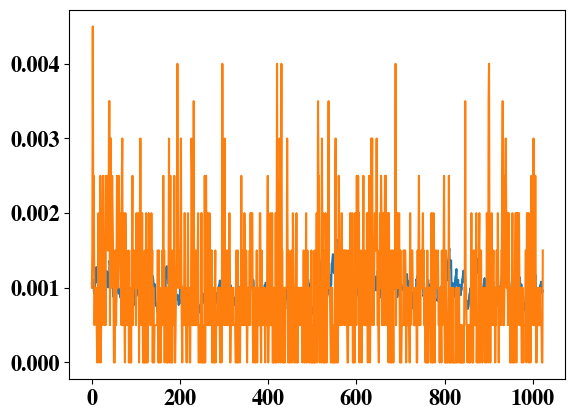

In [112]:
plt.plot(exact_prob)
plt.plot(prob_dist)

In [22]:
sample_size = 20000

seed = 1

E_hist=[]
E_err_hist=[]
grad_hist=[]
grad_err_hist=[]

X=init(seed, complex=True)/40
#X[:N] = np.array([0.1]*N) + X[:N]   #Ferromagnetic Perturbation
#X = np.loadtxt(file+"X_N="+str(N)+"_delta="+str(delta)+"_seed="+str(0)+".txt")
#X = X[-1,:]

smpl = Sampling_Quantum_vectorized(X,N,M,D,beta=beta)
a,b,w,_,_,_ = smpl.get_params()

x0=np.concatenate((np.real(a),np.imag(a),np.real(b),np.imag(b),np.reshape(np.real(w),-1),np.reshape(np.imag(w),-1)))
#x0=np.concatenate((a,b,np.reshape(w,-1)))

tm=time.time()

x = tf.Variable(x0)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta1, beta_2=beta2, epsilon=epsilon)

H = TFIM(1)

for epoch in range(40):
  X = x.numpy()

  a,b,w,u,d,c = get_params(X)
  X=np.concatenate((a,b,np.reshape(w,-1),np.reshape(u,-1),d,np.reshape(c,-1)))
  X=np.concatenate((np.real(X),np.imag(X)))

  smpl = Sampling_Quantum_vectorized(X,N,M,D,beta=beta)

  E = smpl.Energy_exact(H)

  prob_dist, sample_list = Sampling(smpl, sample_size, burn=sample_size//10)

  E_smpl = fun(x,smpl,H,prob_dist)
  print("Energy: ", E, "\t +/- \t", np.abs(E_smpl - E))
  grad = jac(x,smpl,H,prob_dist)

  optimizer.apply_gradients([(grad, x)])

  E_hist.append(E_smpl)
  E_err_hist.append(np.abs(E_smpl - E))


print("\n\n\nEnergy: ",fun(x),"\n Time",time.time()-tm, lmbd[0])

plot_log()

AttributeError: 'OperatorSum' object has no attribute 'get_conn'